# An example Jupyter notebook for paleomagnetic data analysis

This notebook demonstrates a little bit of the functionality that is possible when using PmagPy functions in an interactive notebook environment.

## Import necessary function libraries for the data analysis

The code block below imports necessary libraries from PmagPy that define functions that will be used in the data analysis. You need to have PmagPy installed to run this notebook: https://earthref.org/PmagPy/cookbook/.

In [1]:
import sys
from pmagpy import pmag, pmagplotlib, ipmag

### Scientific Python functions

The numpy, scipy, matplotlib and pandas libraries are standard libraries for scientific python (see http://www.scipy.org). '%matplotlib inline' is necessary to allow the plots to be generated within the notebook instead of in an external window.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Analyzing data from the Snake River Plain

Let's look at data from this study (http://earthref.org/doi/10.1029/2003GC000661): Tauxe, L., Luskin, C., Selkin, P., Gans, P., and Calvert, A., Paleomagnetic results from the Snake River Plain: Contribution to the time-averaged field global database, Geochem. Geophys. Geosyst., doi: 10.1029/2003GC000661, 2004.
http://onlinelibrary.wiley.com/doi/10.1029/2003GC000661/abstract

Download and unpack the data (either with QuickMagIC.py, or using `download_magic.py' on the command line.  Unpack the data into a folder (here called Tauxe04_MagIC) in the same directory as this notebook. 

### Reading data from MagIC format results files

First, the data need to be imported into the notebook environment.
 We will concentrate on importing and using the resulting `pmag_results.txt` file below. The code below relies on the pandas (pd) dataframe structure which is a useful and user friendly way to wrangle data.

In [3]:
# read in the data from the data file as a pandas DataFrame
data = pd.read_csv('Tauxe04_MagIC/pmag_results.txt',sep='	',header=1)
# strip out results that are blank
DI_results = data.dropna(subset = ['average_dec'])
DI_results.head()

,antipodal,average_age,average_age_sigma,average_age_unit,average_alpha95,average_dec,average_inc,average_int,average_int_n,average_int_sigma,...,rock_magnetic_test,tilt_correction,vadm,vadm_sigma,vgp_alpha95,vgp_dm,vgp_dp,vgp_lat,vgp_lon,vgp_n
0,NaN,3.400,0.03,Ma,2.3,330.1,64.9,0.000036,5.0,0.000013,...,ND,0.0,6.050000e+23,8.000000e+22,NaN,4.0,2.7,68.5,177.3,8
1,NaN,1.000,1.00,Ma,3.0,151.8,-57.5,NaN,NaN,NaN,...,ND,0.0,NaN,NaN,NaN,4.1,3.6,-68.2,333.3,7
2,NaN,2.000,0.05,Ma,4.3,16.5,54.6,NaN,NaN,NaN,...,ND,0.0,NaN,NaN,NaN,5.5,5.1,75.2,0.4,5
3,NaN,0.095,0.05,Ma,3.0,14.6,77.9,NaN,NaN,NaN,...,ND,0.0,NaN,NaN,NaN,10.5,3.6,64.7,258.6,7
4,NaN,0.395,0.01,Ma,3.0,346.3,73.8,NaN,NaN,NaN,...,ND,0.0,NaN,NaN,NaN,7.9,3.6,71.1,223.6,7


### Plotting site mean directions

Now we can  plot the using `ipmag.plot_di`.

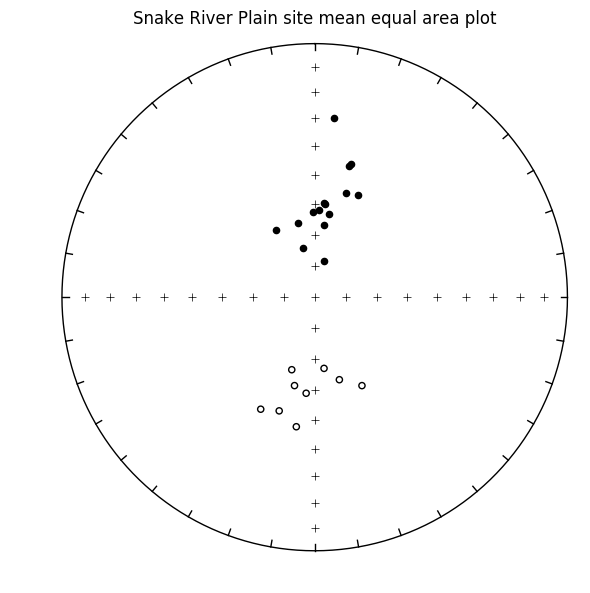

In [4]:
fignum = 1
plt.figure(num=fignum,figsize=(6,6),dpi=160)
ipmag.plot_net(fignum)
plt.title('Snake River Plain site mean equal area plot')
ipmag.plot_di(DI_results['average_dec'],DI_results['average_inc'])

### Calculating and plotting Fisher means from the data

It can be seen in the plot above that the data are of dual polarity. To split the data by polarity, the function `pmag.doprinc` can be used to calculate the principal direction of the data set. This function takes a DIblock which is an array of [dec, inc] values. Results within 90º of the principal direction are of one polarity (reverse in this case), while results greater than 90º from that direction are of the other. This angle can be calculated using the `pmag.angle` function. This `pmag.angle` function can accept single values or arrays of values as is done here.

In [5]:
#make an 2xn array with all the declinations and inclinations
DIblock=np.array([DI_results.average_dec,DI_results.average_inc]).transpose()
# calculate the principle direction for the data set
principal=pmag.doprinc(DIblock)
print 'Principal direction declination: ' + str(principal['dec'])
print 'Principal direction inclination: ' + str(principal['inc'])

Principal direction declination: 5.75807150141
Principal direction inclination: 59.4188169658


In [6]:
DI_results['principal_dec'] = principal['dec']
DI_results['principal_inc'] = principal['inc']
principal_block=np.array([DI_results.principal_dec,DI_results.principal_inc]).transpose()
DI_results['angle'] = pmag.angle(DIblock,principal_block)
DI_results.ix[DI_results.angle>90,'polarity'] = 'Reverse'
DI_results.ix[DI_results.angle<=90,'polarity'] = 'Normal'

Now that polarity is assigned using the angle from the principal component, let's filter the data by polarity and then plot using different colors in order to visually inspect the polarity assignments. 

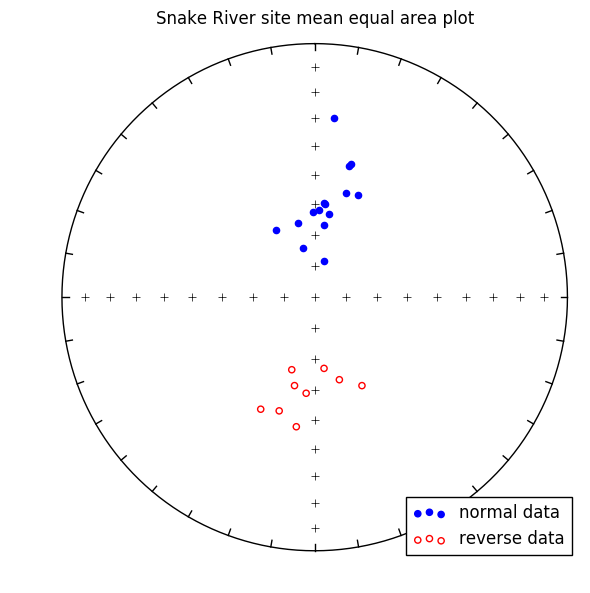

In [7]:
normal_data = DI_results.ix[DI_results.polarity=='Normal'].reset_index(drop=True)
reverse_data = DI_results.ix[DI_results.polarity=='Reverse'].reset_index(drop=True)

plt.figure(num=fignum,figsize=(6,6),dpi=160)
ipmag.plot_net(fignum)
plt.title('Snake River site mean equal area plot')
ipmag.plot_di(normal_data['average_dec'],normal_data['average_inc'],color='b',label='normal data')
ipmag.plot_di(reverse_data['average_dec'],reverse_data['average_inc'],color='r',label='reverse data')
plt.legend(loc=4)
plt.show()

 Fisher means for each polarity can be calculated using the Fisher mean pmag.py function (`pmag.fisher_mean`). This function returns a dictionary that gives the statistics associated with calculating a Fisher mean. These individual values can be called upon (e.g. normal_mean['dec']). Here we make a plot of these calculated means along with their α95 confidence ellipses using ipmag.plot_di_mean.

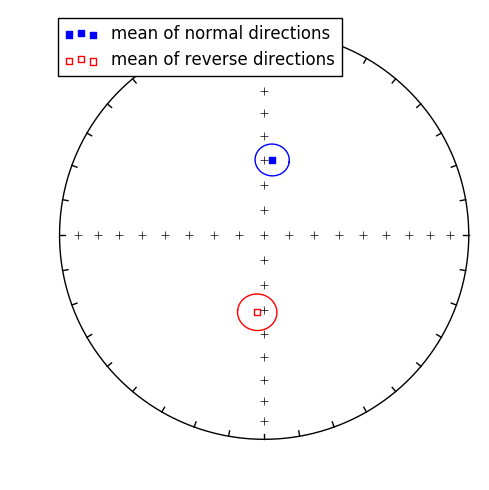

In [8]:
normal_directions = normal_data[['average_dec','average_inc']].values
reverse_directions = reverse_data[['average_dec','average_inc']].values

normal_mean = pmag.fisher_mean(normal_directions)
reverse_mean = pmag.fisher_mean(reverse_directions)

plt.figure(num=fignum,figsize=(5,5))
ipmag.plot_net(fignum)
ipmag.plot_di_mean(normal_mean['dec'],normal_mean['inc'],normal_mean['alpha95'],
                  color='b',marker='s',label='mean of normal directions',legend='yes')
ipmag.plot_di_mean(reverse_mean['dec'],reverse_mean['inc'],reverse_mean['alpha95'],
                  color='r',marker='s',label='mean of reverse directions',legend='yes')

### Conducting reversal tests on the data

Reversal tests are tests for a common mean between two data sets wherein the antipode vectors from one population are compared to the vectors of another population. The code below conducts the Watson V test (also returning the McFadden and McEllhinny (1990) reversal test classification) and conducts a bootstrap reversal test. In order to conduct the test, the antipode of one of the directional populations needs to be taken. The `ipmag.flip` function is used below to return the antipode of the reverse directions in order to conduct the tests.

In [9]:
ipmag.common_mean_watson(normal_directions,ipmag.flip(reverse_directions),NumSims=1000,plot='yes')

AttributeError: 'module' object has no attribute 'flip'

In [ ]:
ipmag.common_mean_bootstrap(normal_directions,ipmag.flip(reverse_directions),NumSims=1000)

### Plotting virtual geomagnetic and mean poles

Now we can use the reverse_data and normal_data dataframes again to look at and analyze the virtual geomagnetic poles (VGPs). After taking the antipode of the reverse VGPs, a `combined_VGP_mean` is calculated using `pmag.fisher_mean`.

In [10]:
# let's take the antipode of the reverse VGPs
reverse_data['vgp_lon_flip'] = reverse_data['vgp_lon']-180.
reverse_data['vgp_lat_flip'] = -reverse_data['vgp_lat']
# here we combine the two sets of VGPs into one 2XN array
combined_vgps = np.concatenate((normal_data[['vgp_lon','vgp_lat']].values,
                                reverse_data[['vgp_lon_flip','vgp_lat_flip']].values))
# and calculate the mean
combined_VGP_mean = pmag.fisher_mean(combined_vgps)
print 'Mean pole longitude: ' + str(combined_VGP_mean['dec'])
print 'Mean pole latitude: ' + str(combined_VGP_mean['inc'])
print 'A_95: ' + str(combined_VGP_mean['alpha95'])

Mean pole longitude: 357.386379026
Mean pole latitude: 86.1186210044
A_95: 5.80948224472


To plot poles we first need a map projection. The matplotlib basemap package does a nice job of that, so let's import it below. Note that not all installations of python will have the basemap package so you may need to download it. It is an availible package through Enthought Canopy.

In [11]:
from mpl_toolkits.basemap import Basemap

The basemap is highly customizable. A view from space type projection ('ortho') is a nice way to view data on a sphere so let's use that one for this example. We will define an object ('m') that is a map projection and then draw additional things on the map such as continents and lat/long lines. Then the VGPs from the study can be plotted using the `ipmag.plot_vgp` function and the mean pole can be plotted using `ipmag.plot_pole`.

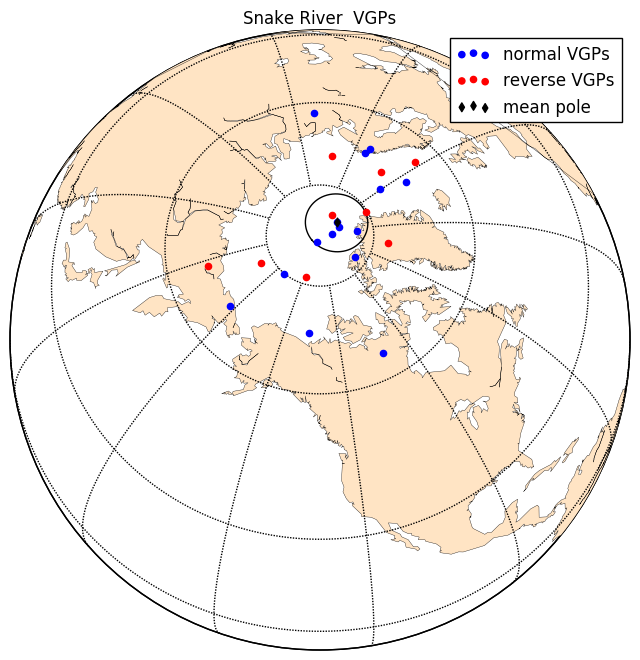

In [12]:
m = Basemap(projection='ortho',lat_0=70,lon_0=230,resolution='c',area_thresh=50000)
plt.figure(figsize=(8, 8))
m.drawcoastlines(linewidth=0.25)
m.fillcontinents(color='bisque',lake_color='white',zorder=1)
m.drawmapboundary(fill_color='white')
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))

ipmag.plot_vgp(m,normal_data['vgp_lon'].tolist(),
               normal_data['vgp_lat'].tolist(),
               color='b',label='normal VGPs')
ipmag.plot_vgp(m,reverse_data['vgp_lon_flip'].tolist(),
               reverse_data['vgp_lat_flip'].tolist(),
               color='r',label='reverse VGPs')
ipmag.plot_pole(m,combined_VGP_mean['dec'],combined_VGP_mean['inc'],
               combined_VGP_mean['alpha95'],marker='d',label='mean pole')
plt.legend()
plt.title('Snake River  VGPs')
plt.show()